# Training a model with `traffic_last_5min` feature


## Introduction

In this notebook, we'll train a taxifare prediction model but this time with an additional feature of `traffic_last_5min`.

In [17]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)
%matplotlib inline

2.1.1


In [18]:
BUCKET =  "qwiklabs-gcp-04-8722038efd75"
PROJECT = "qwiklabs-gcp-04-8722038efd75"
REGION = "us-west1"

In [19]:
# For Bash Code
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [20]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Load raw data

In [21]:
!ls -l ../data/taxi-traffic*

-rw-r--r-- 1 jupyter jupyter 2186310 Nov 29 03:14 ../data/taxi-traffic-test.csv
-rw-r--r-- 1 jupyter jupyter 9713118 Nov 29 03:14 ../data/taxi-traffic-train.csv
-rw-r--r-- 1 jupyter jupyter 2036826 Nov 29 03:14 ../data/taxi-traffic-valid.csv


In [22]:
!head ../data/taxi-traffic*

==> ../data/taxi-traffic-test.csv <==
15.7,6,12,-73.990072,40.758199,-73.974686,40.742004,2089
6.1,7,2,-73.95647,40.771226,-73.971845,40.750089,1738
4.1,6,18,-73.987871,40.759855,-73.996375,40.763728,2971
5.7,2,18,-73.974177,40.761154,-73.980953,40.769357,2320
7.4,4,23,-73.924908,40.741879,-73.897524,40.747867,1491
20.5,1,15,-73.957528,40.766847,-73.870813,40.774044,1794
6.5,6,9,-73.996553,40.725558,-73.992503,40.737248,2341
4.1,4,11,-73.98353,40.746821000000004,-73.976831,40.751082000000004,2329
10.5,3,18,-73.863998,40.770439,-73.91671099999999,40.773011,2318
10.1,6,1,-73.979685,40.727247999999996,-73.952508,40.772492,1455

==> ../data/taxi-traffic-train.csv <==
6.1,2,0,-73.98689499999999,40.729723,-74.00631,40.739407,1129
9.7,7,0,-73.94578299999999,40.777807,-73.97539,40.757712,2876
5.3,6,0,-74.00644,40.739349,-73.999379,40.731804,3950
7.3,5,0,-73.96611800000001,40.753983000000005,-73.945605,40.782802000000004,1334
6.5,7,0,-73.974153,40.762767,-73.989152,40.742727,2623
22.9,1,0,-73.9

## Use tf.data to read the CSV files

These functions for reading data from the csv files are similar to what we used in the Introduction to Tensorflow module. Note that here we have an addtional feature `traffic_last_5min`.

In [23]:
CSV_COLUMNS = [
    'fare_amount',
    'dayofweek',
    'hourofday',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'traffic_last_5min'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    return features, label


def create_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels)

    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

In [25]:
INPUT_COLS = [
    'dayofweek',
    'hourofday',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'traffic_last_5min'
]

# Create input layer of feature columns
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
    }

## Build a simple keras DNN model

In [26]:
# Build a keras DNN model using Sequential API
def build_model(dnn_hidden_units):
    model = Sequential(DenseFeatures(feature_columns=feature_columns.values()))
    
    for num_nodes in dnn_hidden_units:
        model.add(Dense(units=num_nodes, activation="relu"))
    
    model.add(Dense(units=1, activation="linear"))    
    
    # Create a custom evalution metric
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

Next, we can call the `build_model` to create the model. Here we'll have two hidden layers before our final output layer. And we'll train with the same parameters we used before.

In [27]:
HIDDEN_UNITS = [32, 8]

model = build_model(dnn_hidden_units=HIDDEN_UNITS)

In [28]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 6  # training dataset will repeat, wrap around
NUM_EVALS = 60  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='../data/taxi-traffic-train*',
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

evalds = create_dataset(
    pattern='../data/taxi-traffic-valid*',
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

In [29]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(LOGDIR)])

Train for 1 steps, validate for 10 steps
Epoch 1/60
1/1 [==============================] - 16s 16s/step - loss: 423586.7500 - rmse: 650.8354 - mse: 423586.7500 - val_loss: 379166.0156 - val_rmse: 615.6774 - val_mse: 379166.0000
Epoch 2/60
1/1 [==============================] - 1s 1s/step - loss: 394578.4062 - rmse: 628.1548 - mse: 394578.4062 - val_loss: 354315.8844 - val_rmse: 595.1910 - val_mse: 354315.8750
Epoch 3/60
1/1 [==============================] - 1s 716ms/step - loss: 502715.7188 - rmse: 709.0245 - mse: 502715.7188 - val_loss: 327593.0750 - val_rmse: 572.2736 - val_mse: 327593.0312
Epoch 4/60
1/1 [==============================] - 1s 666ms/step - loss: 542916.2500 - rmse: 736.8285 - mse: 542916.2500 - val_loss: 300725.2031 - val_rmse: 548.3168 - val_mse: 300725.1875
Epoch 5/60
1/1 [==============================] - 1s 551ms/step - loss: 316079.6250 - rmse: 562.2096 - mse: 316079.6250 - val_loss: 273455.5375 - val_rmse: 522.8859 - val_mse: 273455.5312
Epoch 6/60
1/1 [=======

<AxesSubplot:>

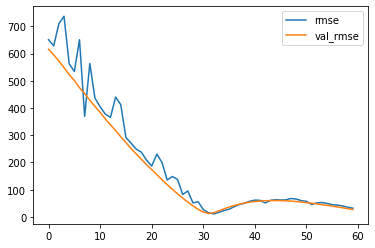

In [30]:
RMSE_COLS = ['rmse', 'val_rmse']

pd.DataFrame(history.history)[RMSE_COLS].plot()

In [31]:
model.predict(x={"dayofweek": tf.convert_to_tensor([6]),
                 "hourofday": tf.convert_to_tensor([17]),
                 "pickup_longitude": tf.convert_to_tensor([-73.982683]),
                 "pickup_latitude": tf.convert_to_tensor([40.742104]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
                 "dropoff_latitude": tf.convert_to_tensor([40.755174]),
                "traffic_last_5min": tf.convert_to_tensor([114])},
              steps=1)

array([[-2.4741225]], dtype=float32)

## Export and deploy model

In [32]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR,
                           datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(model, EXPORT_PATH)  # with default serving function
os.environ['EXPORT_PATH'] = EXPORT_PATH

INFO:tensorflow:Assets written to: ./export/savedmodel/20201208135219/assets


In [33]:
%%bash
PROJECT=${PROJECT}
BUCKET=${BUCKET}
REGION=${REGION}
MODEL_NAME=taxifare
VERSION_NAME=traffic

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.7 --runtime-version=2.1 \
       --origin=${EXPORT_PATH} --staging-bucket=gs://$BUCKET

taxifare already exists
Creating taxifare:traffic


Using endpoint [https://ml.googleapis.com/]
Using endpoint [https://ml.googleapis.com/]
Using endpoint [https://ml.googleapis.com/]


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License